In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import numpy as np
# Imports

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%config InlineBackend.figure_format='retina'

# 1. Data cleaning

In [2]:
df_ini = pd.read_excel('data.xlsx')

In [3]:
df_ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9984 entries, 0 to 9983
Data columns (total 7 columns):
top_tube              9980 non-null float64
seat_tube             9982 non-null float64
chainstay             9976 non-null float64
front_center          9982 non-null float64
battery_weight        9981 non-null float64
fullcharge_voltage    9983 non-null float64
battery_capacity      9984 non-null float64
dtypes: float64(7)
memory usage: 546.1 KB


In [4]:
# check the number of missing data points 
df_ini.isnull().sum()

top_tube              4
seat_tube             2
chainstay             8
front_center          2
battery_weight        3
fullcharge_voltage    1
battery_capacity      0
dtype: int64

In [5]:
# drop rows that have missing data
df_ini = df_ini.dropna(axis=0)

In [6]:
# looking at the initial description, the minimum values of top_tube, seat_tube, and chainstay showed some outlier 
df_ini.describe()

,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,9964.000000,9964.000000,9964.000000,9964.000000,9964.000000,9964.000000,9964.000000
mean,601.951833,583.299927,485.921051,633.005381,2.799979,35.891157,0.392823
std,8.574512,63.271036,105.053884,1.159424,0.004163,0.432715,0.028309
min,0.000000,-5677.870000,-9999.000000,629.310812,2.784446,34.088173,0.278370
25%,601.638267,583.372428,486.291759,632.572078,2.797189,35.953852,0.399263
50%,602.007695,584.007567,486.971322,632.983858,2.800005,35.994935,0.399942
75%,602.406281,584.646154,487.659336,633.396206,2.802749,36.034813,0.400550
max,605.915751,588.694467,490.802967,638.849165,2.814514,36.223812,0.403521


In [7]:
# check the number of top_tube outliers
df_ini.loc[df_ini.loc[:, 'top_tube'] < 500]

,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
4807,0.0,583.073959,485.680586,631.170166,2.796068,36.012398,0.399872
4825,0.0,583.437742,487.680319,637.105301,2.805226,35.939678,0.399676


In [8]:
# drop top_tube outliers
invalid_top_tube = df_ini.loc[df_ini.loc[:, 'top_tube'] < 500].index
df_ini = df_ini.drop(invalid_top_tube)

In [9]:
# check the number of seat_tube outliers 
df_ini.loc[df_ini.loc[:, 'seat_tube'] < 500]

,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
4966,601.898042,-234.00,485.334169,633.195436,2.798382,35.941504,0.398977
4990,601.657326,-5677.87,486.307252,633.494447,2.802893,35.928574,0.399015


In [10]:
# drop seat_tube outliers
invalid_seat_tube = df_ini.loc[df_ini.loc[:, 'seat_tube'] < 500].index
df_ini = df_ini.drop(invalid_seat_tube)

In [11]:
# check the number of chainstay outliers
df_ini.loc[df_ini.loc[:, 'chainstay'] < 400]

,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
4993,602.013774,583.589222,-9999.0,632.215675,2.797903,35.925383,0.398128


In [12]:
# drop chainstay outliers
invalid_chainstay = df_ini.loc[df_ini.loc[:, 'chainstay'] < 400].index
df_ini = df_ini.drop(invalid_chainstay)

In [13]:
# save the clean data set 
df_ini.to_excel('data_clean.xlsx', index=False)

In [14]:
df = pd.read_excel('data_clean.xlsx')

In [15]:
df.describe()

,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000
mean,602.072748,584.010668,486.973728,633.005165,2.799979,35.891128,0.392820
std,0.877312,0.943352,1.013663,1.158802,0.004163,0.432821,0.028316
min,599.040237,580.228518,483.227181,629.310812,2.784446,34.088173,0.278370
25%,601.638459,583.373295,486.292196,632.572101,2.797189,35.953900,0.399264
50%,602.008034,584.008273,486.971547,632.983655,2.800006,35.995017,0.399943
75%,602.406466,584.646428,487.659394,633.396153,2.802748,36.034850,0.400550
max,605.915751,588.694467,490.802967,638.849165,2.814514,36.223812,0.403521


# 2. Data grouping and scaling
## 2.1. Data grouping
We will divide the initial dataset into Frame and Battery groups and analyze them separately

In [16]:
df_frame = df.loc[:, ['top_tube', 'seat_tube','chainstay', 'front_center']]
df_battery = df.loc[:, ['battery_weight', 'fullcharge_voltage','battery_capacity']]

In [17]:
df_frame.corr()

,top_tube,seat_tube,chainstay,front_center
top_tube,1.000000,0.013541,0.010755,-0.665229
seat_tube,0.013541,1.000000,-0.024120,-0.020901
chainstay,0.010755,-0.024120,1.000000,0.001001
front_center,-0.665229,-0.020901,0.001001,1.000000


In [18]:
df_battery.corr()

,battery_weight,fullcharge_voltage,battery_capacity
battery_weight,1.000000,0.018992,0.017599
fullcharge_voltage,0.018992,1.000000,0.991547
battery_capacity,0.017599,0.991547,1.000000


## 2.2. Data scaling

In [19]:
df_framescaled = (df_frame - df_frame.min()) / (df_frame.max() - df_frame.min())
df_batteryscaled = (df_battery - df_battery.min()) / (df_battery.max() - df_battery.min())
df_scaled = (df - df.min()) / (df.max() - df.min())

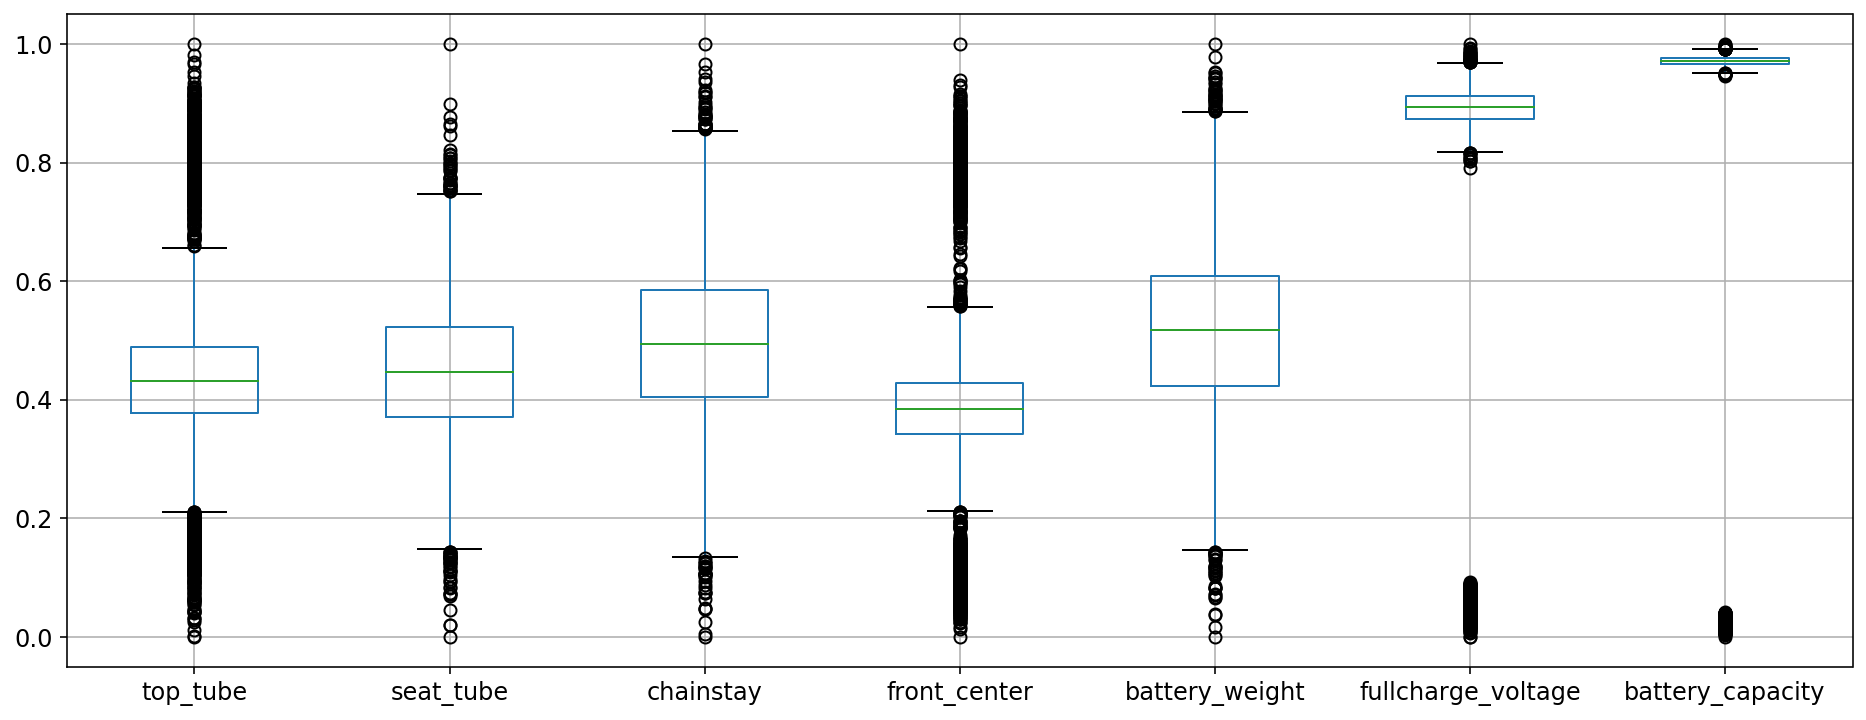

In [20]:
fig, ax = plt.subplots()
df_scaled.boxplot(ax=ax, grid = True, fontsize = 12) 

fig.set_figwidth(16)
fig.set_figheight(6)

# 3. Frame analysis 
## 3.1. Principal component analysis

In [21]:
pca_frame = PCA()
pca_frame.fit_transform(df_framescaled)

array([[ 0.61402671,  0.17372683, -0.05942657,  0.09785009],
       [ 0.00672175,  0.05786438, -0.03638924, -0.11629283],
       [-0.47863603,  0.06828441,  0.05182626, -0.02938361],
       ...,
       [-0.04881866,  0.01253615, -0.03787028, -0.00945416],
       [ 0.53789697, -0.19092286,  0.08051048,  0.0218202 ],
       [ 0.06011072,  0.0472677 , -0.07241906, -0.05111159]])

In [22]:
pca_frame.explained_variance_ratio_

array([0.42161831, 0.29215716, 0.20183819, 0.08438634])

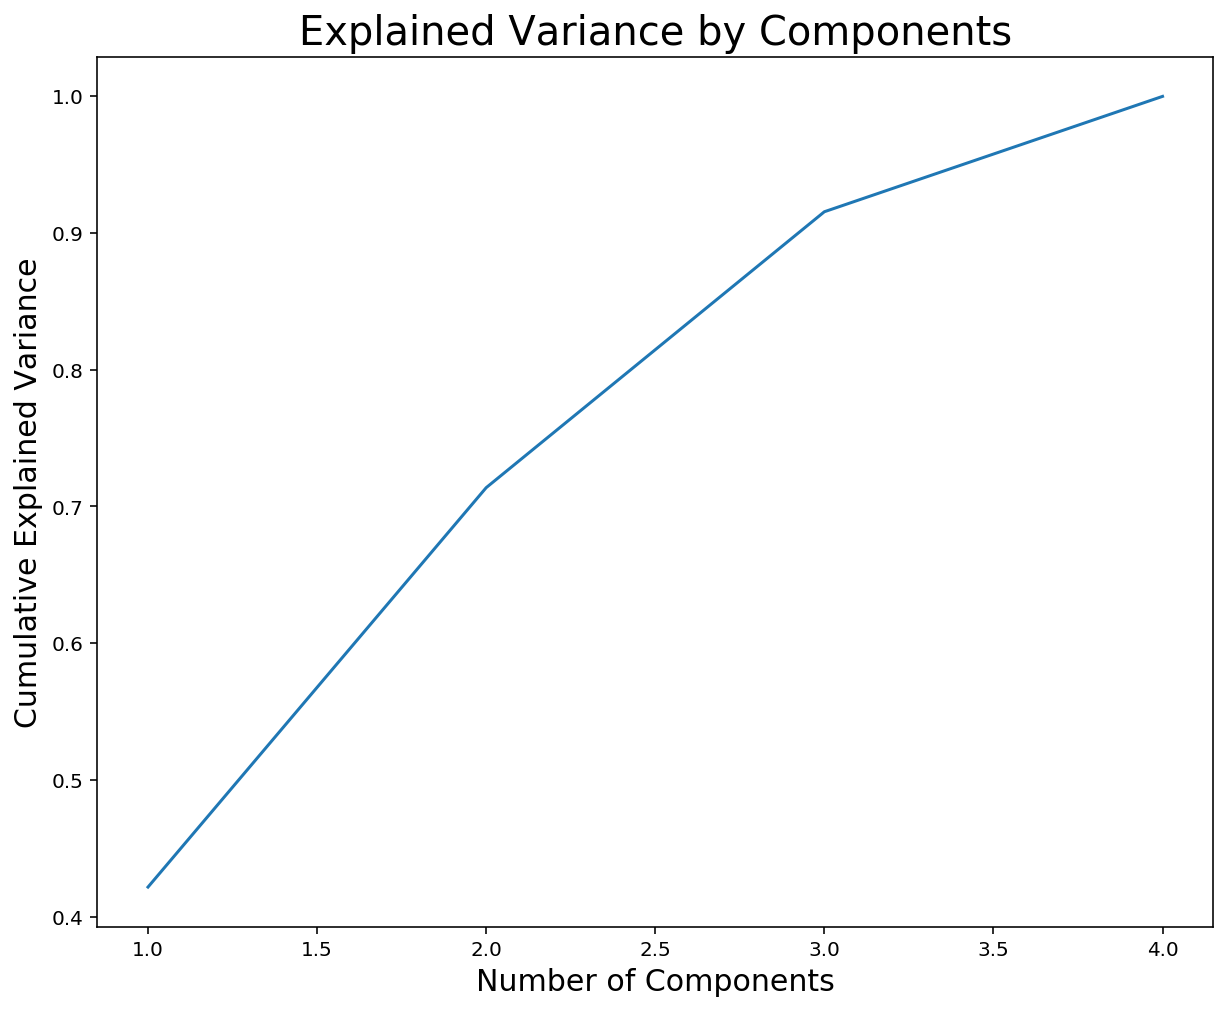

In [23]:
# line chart to depict the cummulated explained variance ratios
plt.figure(figsize = (10,8))
plt.plot(range(1,5), pca_frame.explained_variance_ratio_.cumsum())
plt.title('Explained Variance by Components', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Cumulative Explained Variance', fontsize = 15)
plt.savefig('Explained Variance by Components_Frame.png')

In [24]:
pca_frame =PCA(n_components = 3)

In [25]:
pca_frame.fit_transform(df_framescaled)

array([[ 0.61402671,  0.17372683, -0.05942657],
       [ 0.00672175,  0.05786438, -0.03638924],
       [-0.47863603,  0.06828441,  0.05182626],
       ...,
       [-0.04881866,  0.01253615, -0.03787028],
       [ 0.53789697, -0.19092286,  0.08051048],
       [ 0.06011072,  0.0472677 , -0.07241906]])

In [26]:
print(abs( pca_frame.components_ ))
# most important features for each principal component, tells us how much a feature/variable explains a component
# PC1 -> var 1 and var 4 (top tube and front center, maybe due to high correlation between these variables)
# PC2 -> var 3 (chainstay)
# PC 3 -> var 2 (seat tube)

[[0.73237625 0.024402   0.01438675 0.68031066]
 [0.0017783  0.06603369 0.99767411 0.01681518]
 [0.02486961 0.99746865 0.06580053 0.01039669]]


In [27]:
#We’ll incorporate the newly obtained PCA scores in the K-means algorithm. 
#That’s how we can perform segmentation based on principal components scores instead of the original features.
df_frame_PCA = pd.DataFrame(data = pca_frame.fit_transform(df_framescaled)
             , columns = ['PC 1', 'PC 2', 'PC 3'])
df_frame_PCA.head(3)

,PC 1,PC 2,PC 3
0,0.614027,0.173727,-0.059427
1,0.006722,0.057864,-0.036389
2,-0.478636,0.068284,0.051826


## 3.2. K-means clustering

In [28]:
kmeans_frame = KMeans(n_clusters=8, random_state=0)

To run the clustering algorithm to cluster the rows of df_frame_PCA, (the data set has been reduced dimensions), use kmeans_frame.fit(df_frame_PCA).
The cluster that each row of the dataframe is assigned to is stored in kmeans_frame.labels_

In [29]:
kmeans_frame.fit(df_frame_PCA)
kmeans_frame.labels_

array([6, 1, 4, ..., 1, 6, 7], dtype=int32)

In [30]:
kmeans_frame.inertia_

142.0754844912372

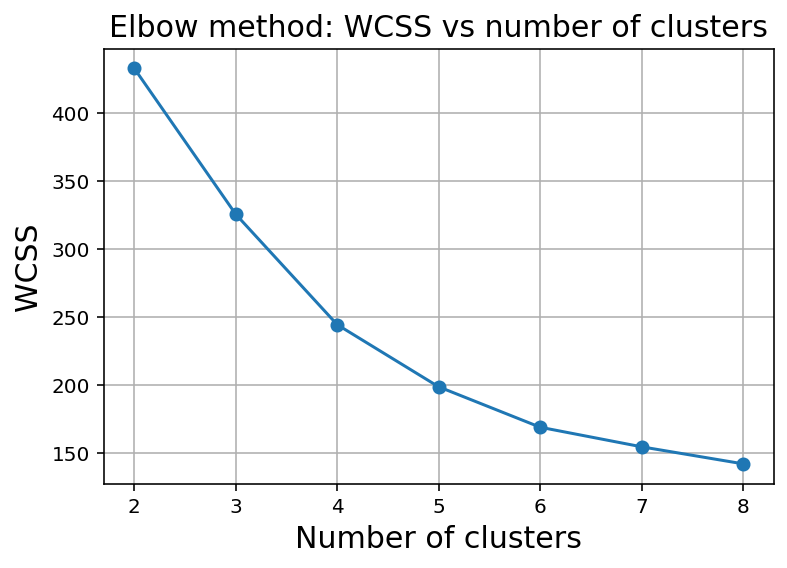

In [31]:
#### Determining the data for elbow method
K_min, K_max = (2, 8)
WCSS_frame = []

for K in range(K_min, K_max+1):
    kmeans_frame.n_clusters = K    
    kmeans_frame.fit(df_frame_PCA)
    WCSS_frame.append(kmeans_frame.inertia_)
    
    
#### Plotting
fig, ax = plt.subplots()

ax.plot(range(K_min, K_max+1), WCSS_frame, marker='o')

ax.set_xlabel('Number of clusters', fontsize = 15)
ax.set_ylabel('WCSS', fontsize = 15)
ax.set_title('Elbow method: WCSS vs number of clusters', fontsize = 15)
ax.set_xticks(range(K_min, K_max+1))
ax.grid()
fig.savefig('Elbow method: WCSS vs number of clusters_Frame.png')

0.714392476394489
1.1864284047717064
0.9769300935329024
0.9623585804775836
0.9476499879867492
1.0070465839039962
1.0173572997543787


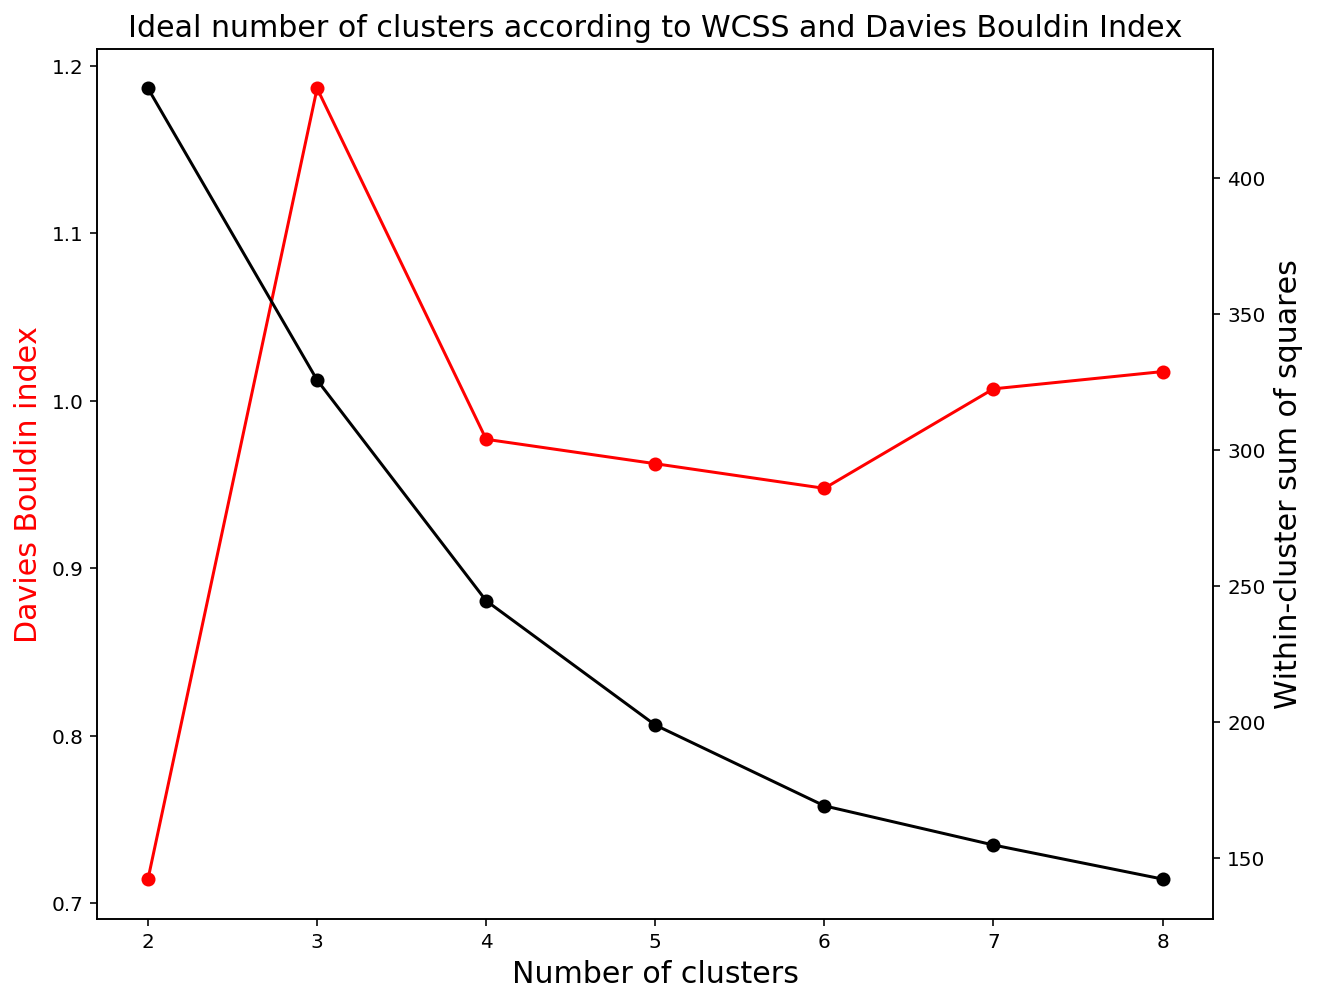

In [32]:
import sklearn.metrics as metrics
scores_frame = []
k = [2, 3, 4, 5, 6, 7, 8]
for i in k:
    y_frame = KMeans(n_clusters = i, max_iter=1000, random_state = 0).fit_predict(df_frame_PCA)
    score_b = metrics.davies_bouldin_score(df_frame_PCA, y_frame)
    scores_frame.append(score_b)
    print(score_b)
    
fig, ax3 = plt.subplots(figsize=(10,8))
ax4 = ax3.twinx() 

ax3.plot(k, scores_frame, 'r-', marker = 'o')
ax4.plot(k, WCSS_frame, 'k-', marker = 'o')

plt.title('Ideal number of clusters according to WCSS and Davies Bouldin Index', fontsize = 15)
ax3.set_xlabel('Number of clusters', fontsize = 15)
ax3.set_ylabel('Davies Bouldin index', color='r', fontsize = 15)
ax4.set_ylabel('Within-cluster sum of squares', color='k', fontsize = 15)

plt.show()
fig.savefig('Ideal number of clusters_Frame.png')

In [33]:
# run K-means with number of clusters equal 5
K = 5
kmeans_frame_pca = KMeans(n_clusters = K, init ='k-means++', random_state =42)
# fit data with k-means pca model
kmeans_frame_pca.fit(df_frame_PCA)
df_frame_PCA.loc[:, 'cluster'] = kmeans_frame_pca.labels_

In [34]:
# transform the nominal values of top tube, seat tube, chain stay and front center
ideal_frame = pd.DataFrame(data={'top_tube': [602], 'seat_tube': [584], 'chainstay': [487], 'front_center': [633]})
ideal_frame = (ideal_frame - df_frame.min()) / (df_frame.max() - df_frame.min())
ideal_frame = pca_frame.transform(ideal_frame)
ideal_frame = pd.DataFrame(ideal_frame, columns=['c1', 'c2', 'c3'])
print (ideal_frame)
print(f"Ideal bike frame belongs to cluster {kmeans_frame_pca.predict(ideal_frame)[0]}")

         c1        c2        c3
0  0.007362  0.003553 -0.000771
Ideal bike frame belongs to cluster 0


### Depict the clusters in a 2D scatter plot by utilizing the tranformed data

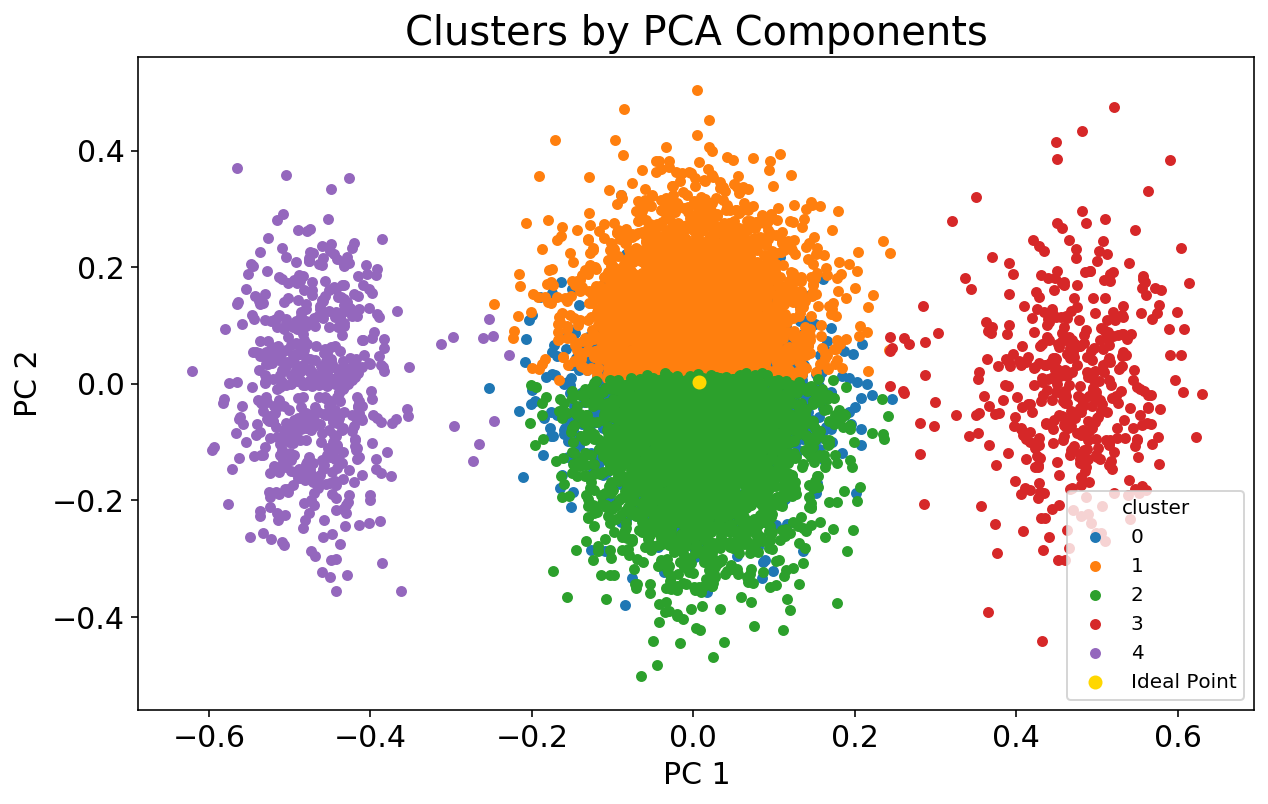

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

for cluster in range(K):
    df_frame_PCA.groupby('cluster').get_group(cluster).plot.scatter('PC 1', 'PC 2', 
                                                                 color='C' + str(cluster),
                                                                 ax=ax, label=cluster, fontsize = 15)
a = ideal_frame['c1']
b = ideal_frame['c2']
ax.scatter(a, b, color='gold', label='Ideal Point')

ax.legend(title='cluster', fontsize = 10, title_fontsize = 10)

#Plot data by PCA Components. The X axis is the first component, Y axis is the second
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)

plt.title('Clusters by PCA Components', fontsize = 20)
plt.show()
fig.savefig('Clusters by PCA Components_PC1_2_Frame.png')

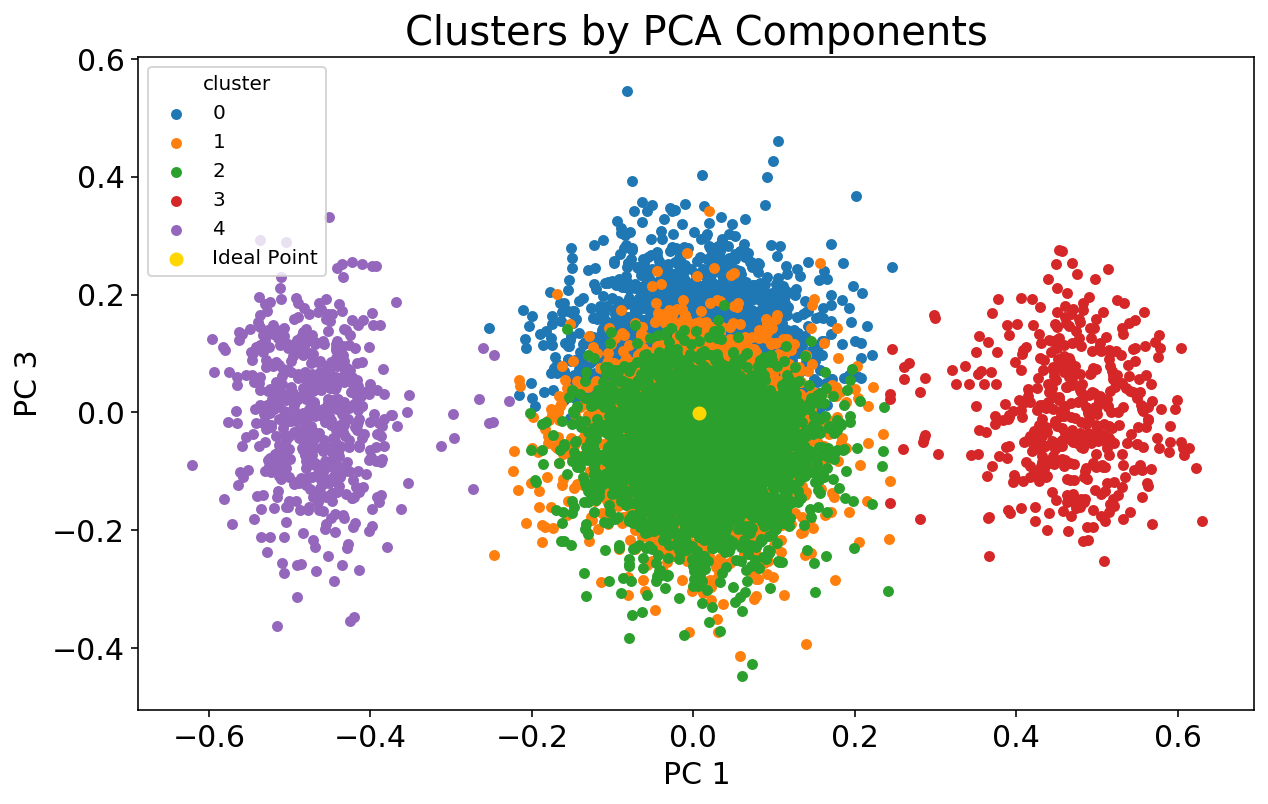

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

for cluster in range(K):
    df_frame_PCA.groupby('cluster').get_group(cluster).plot.scatter('PC 1', 'PC 3', 
                                                                 color='C' + str(cluster),
                                                                 ax=ax, label=cluster, fontsize = 15)
a = ideal_frame['c1']
b = ideal_frame['c3']
ax.scatter(a, b, color='gold', label='Ideal Point')

ax.legend(title='cluster', fontsize = 10, title_fontsize = 10)

#Plot data by PCA Components. The X axis is the first component, Y axis is the second
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 3', fontsize = 15)

plt.title('Clusters by PCA Components', fontsize = 20)
plt.show()
fig.savefig('Clusters by PCA Components_PC1_3_Frame.png')

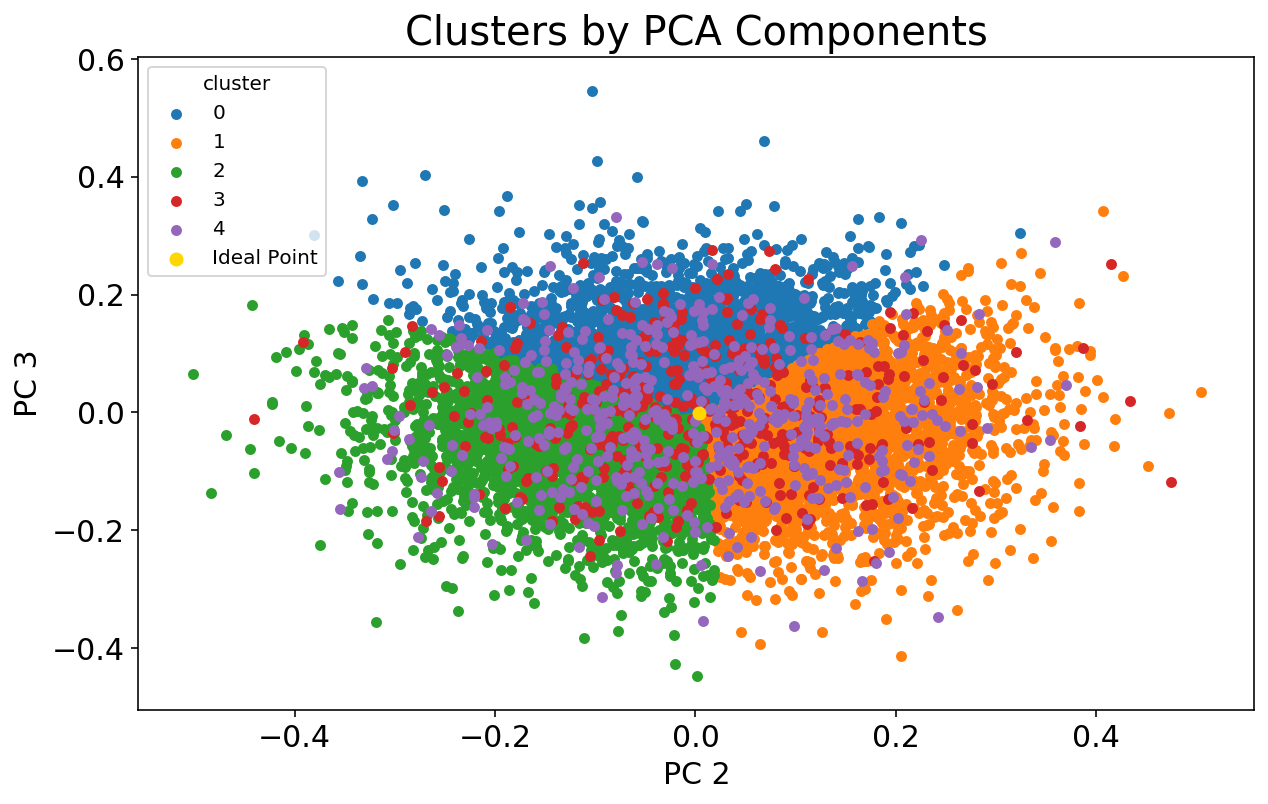

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

for cluster in range(K):
    df_frame_PCA.groupby('cluster').get_group(cluster).plot.scatter('PC 2', 'PC 3', 
                                                                 color='C' + str(cluster),
                                                                 ax=ax, label=cluster, fontsize = 15)
a = ideal_frame['c2']
b = ideal_frame['c3']
ax.scatter(a, b, color='gold', label='Ideal Point')

ax.legend(title='cluster', fontsize = 10, title_fontsize = 10)

#Plot data by PCA Components. The X axis is the first component, Y axis is the second
ax.set_xlabel('PC 2', fontsize = 15)
ax.set_ylabel('PC 3', fontsize = 15)

plt.title('Clusters by PCA Components', fontsize = 20)
plt.show()
fig.savefig('Clusters by PCA Components_PC2_3_Frame.png')

### Describe and calculate the percentage of each cluster

In [38]:
clusterframe_0 = df.iloc[np.where(kmeans_frame_pca.labels_ == 0)]
print(f"{round(len(clusterframe_0)/len(df)*100, 2)}% of bike frames belong to cluster 0")
clusterframe_0.describe()

28.24% of bike frames belong to cluster 0


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,2812.000000,2812.000000,2812.000000,2812.000000,2812.000000,2812.000000,2812.000000
mean,601.998879,584.962837,486.889788,632.988222,2.800104,35.890455,0.392836
std,0.515824,0.596149,0.651438,0.559162,0.004144,0.432736,0.028334
min,599.768077,583.907299,484.261337,629.699596,2.784940,34.088173,0.278824
25%,601.671452,584.521851,486.486185,632.627816,2.797306,35.954073,0.399281
50%,601.995464,584.890345,486.913904,632.992867,2.800131,35.993525,0.399984
75%,602.336286,585.329081,487.290494,633.344714,2.802844,36.034126,0.400572
max,604.225675,588.694467,489.586453,634.812685,2.812734,36.208308,0.402932


In [39]:
clusterframe_1 = df.iloc[np.where(kmeans_frame_pca.labels_ == 1)]
print(f"{round(len(clusterframe_1)/len(df)*100, 2)}% of bike frames belong to cluster 1")
clusterframe_1.describe()

31.78% of bike frames belong to cluster 1


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,3165.000000,3165.000000,3165.000000,3165.000000,3165.000000,3165.000000,3165.000000
mean,602.021299,583.602228,487.935831,632.997101,2.799991,35.886902,0.392530
std,0.525870,0.755275,0.628378,0.554134,0.004126,0.440997,0.028855
min,599.766678,580.401824,486.982885,631.044581,2.785615,34.089134,0.279002
25%,601.692090,583.137066,487.424873,632.635779,2.797252,35.953917,0.399265
50%,602.026090,583.633690,487.848683,633.001833,2.800072,35.996161,0.399927
75%,602.370819,584.102971,488.342303,633.360743,2.802774,36.034291,0.400558
max,604.313027,586.668577,490.802967,635.475020,2.814514,36.205621,0.403521


In [40]:
clusterframe_2 = df.iloc[np.where(kmeans_frame_pca.labels_ == 2)]
print(f"{round(len(clusterframe_2)/len(df)*100, 2)}% of bike frames belong to cluster 2")
clusterframe_2.describe()

30.2% of bike frames belong to cluster 2


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000
mean,601.994177,583.555549,486.045182,632.991718,2.799921,35.880274,0.392066
std,0.526051,0.713531,0.643081,0.570891,0.004216,0.453161,0.029649
min,599.364767,580.228518,483.227181,630.460805,2.785537,34.107511,0.279236
25%,601.653389,583.121077,485.652492,632.615736,2.797052,35.951269,0.399245
50%,601.986757,583.621594,486.148913,632.984688,2.799898,35.994243,0.399926
75%,602.338264,584.031385,486.548538,633.371883,2.802718,36.036129,0.400532
max,604.929060,585.802316,487.008213,635.245987,2.813830,36.223812,0.403210


In [41]:
clusterframe_3 = df.iloc[np.where(kmeans_frame_pca.labels_ == 3)]
print(f"{round(len(clusterframe_3)/len(df)*100, 2)}% of bike frames belong to cluster 3")
clusterframe_3.describe()

4.3% of bike frames belong to cluster 3


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,600.234905,583.922130,486.940714,636.775588,2.799541,35.908125,0.394178
std,0.424027,0.875193,1.018397,0.778709,0.004262,0.393488,0.025652
min,599.040237,581.692568,483.588007,633.288730,2.784446,34.146809,0.280090
25%,599.931680,583.299973,486.296209,636.459113,2.796631,35.955652,0.399366
50%,600.245615,583.878680,486.890534,636.863522,2.799520,35.990957,0.399967
75%,600.527181,584.546462,487.565851,637.262375,2.802312,36.030905,0.400490
max,601.590570,586.244766,490.446330,638.849165,2.810676,36.144222,0.401993


In [42]:
clusterframe_4 = df.iloc[np.where(kmeans_frame_pca.labels_ == 4)]
print(f"{round(len(clusterframe_4)/len(df)*100, 2)}% of bike frames belong to cluster 4")
clusterframe_4.describe()

5.48% of bike frames belong to cluster 4


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,604.624928,584.051143,486.970386,630.257684,2.799924,35.965561,0.397512
std,0.402419,0.953154,1.013568,0.370509,0.004092,0.259063,0.016804
min,603.086895,581.006907,484.247025,629.310812,2.788773,34.157021,0.278370
25%,604.357523,583.398575,486.257493,630.028205,2.796992,35.960693,0.399270
50%,604.631046,584.044339,487.005882,630.237432,2.800021,36.002176,0.399867
75%,604.899681,584.717749,487.716328,630.456015,2.802545,36.038423,0.400550
max,605.915751,586.943416,489.882022,632.609633,2.811661,36.153299,0.402259


# 4. Battery Analysis
## 4.1. Principal Component Analysis 

In [43]:
pca_battery = PCA()
pca_battery.fit_transform(df_batteryscaled)

array([[-0.04920024, -0.06478585,  0.02788749],
       [-0.08530117,  0.033697  , -0.0205773 ],
       [-0.07386212,  0.07426119, -0.00191138],
       ...,
       [-0.10712359,  0.04656107, -0.02265381],
       [-0.07745195,  0.20370328, -0.00501254],
       [-0.08707857,  0.14393454, -0.00790197]])

In [44]:
pca_battery.explained_variance_ratio_

array([0.82456328, 0.17198024, 0.00345648])

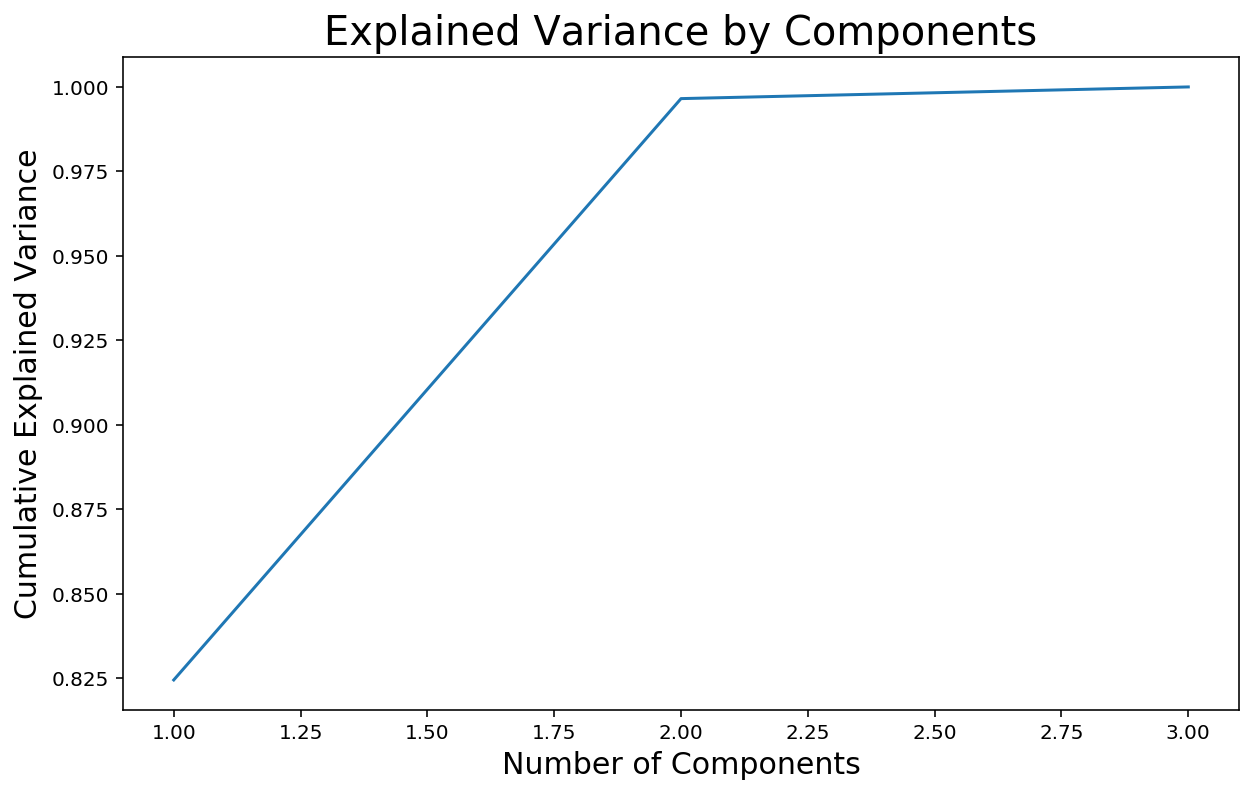

In [45]:
plt.figure(figsize = (10,6))
plt.plot(range(1,4), pca_battery.explained_variance_ratio_.cumsum())
plt.title('Explained Variance by Components', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Cumulative Explained Variance', fontsize = 15)
plt.savefig('Explained Variance by Components_Battery.png')

In [46]:
# set n=2 to explain 96% of the total variance
pca_battery =PCA(n_components = 2)

In [47]:
#We need only the calculated resulting components scores for the elements in our data set
pca_battery.fit_transform(df_batteryscaled)

array([[-0.04920024, -0.06478585],
       [-0.08530117,  0.033697  ],
       [-0.07386212,  0.07426119],
       ...,
       [-0.10712359,  0.04656107],
       [-0.07745195,  0.20370328],
       [-0.08707857,  0.14393454]])

In [48]:
df_battery_PCA = pd.DataFrame(data = pca_battery.fit_transform(df_batteryscaled)
             , columns = ['PC 1', 'PC 2'])
df_battery_PCA.head(10)

,PC 1,PC 2
0,-0.049200,-0.064786
1,-0.085301,0.033697
2,-0.073862,0.074261
3,-0.075738,0.104757
4,-0.077647,0.220361
5,-0.059452,-0.107761
6,-0.046771,0.024274
7,-0.085276,-0.184438
8,-0.071772,-0.042553
9,-0.063407,0.253607


In [49]:
print(abs( pca_battery.components_ ))
# most important features for each principal component, tells us how much a feature/variable explains a component
# PC1 -> var 2 and var 3 (voltage and capacity --> high correlation between these variables)
# PC2 -> var 1 (battery weight)

[[0.01053746 0.66683347 0.74513226]
 [0.99994325 0.00585752 0.00889891]]


## 4.2. K-means clustering

In [50]:
from sklearn.cluster import KMeans
kmeans_battery = KMeans(n_clusters=8, random_state=0)

To run the clustering algorithm to cluster the rows of df_battery_PCA, (the data set has been modificed by PCA), use kmeans_battery.fit(df_battery_PCA).
The cluster that each row of the dataframe is assigned to is stored in kmeans_battery.labels_

In [51]:
kmeans_battery.fit(df_battery_PCA)
kmeans_battery.labels_

array([6, 5, 5, ..., 5, 0, 0], dtype=int32)

In [52]:
kmeans_battery.inertia_

17.39733093047413

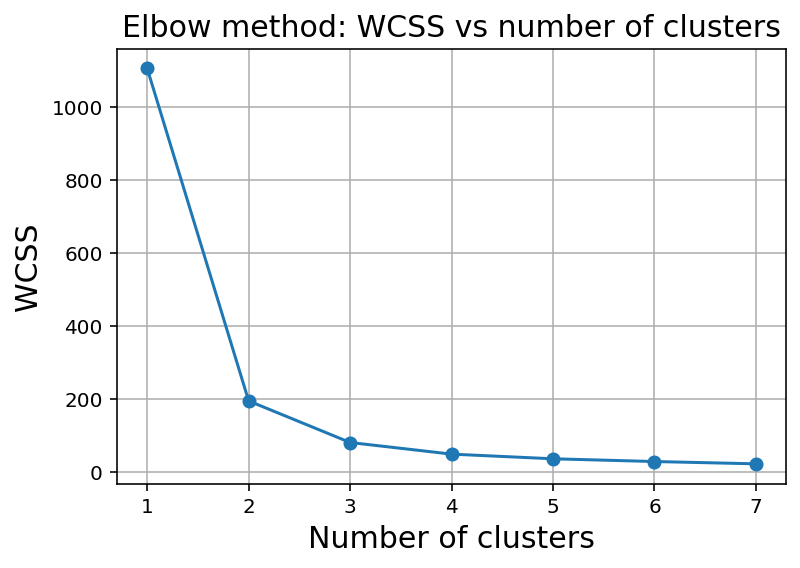

In [53]:
#### Determining the data for elbow method
K_min, K_max = (1, 7)
WCSS_battery = []

for K in range(K_min, K_max+1):
    kmeans_battery.n_clusters = K    
    kmeans_battery.fit(df_battery_PCA)
    WCSS_battery.append(kmeans_battery.inertia_)
    
    
#### Plotting
fig, ax = plt.subplots()

ax.plot(range(K_min, K_max+1), WCSS_battery, marker='o')

ax.set_xlabel('Number of clusters', fontsize = 15)
ax.set_ylabel('WCSS', fontsize = 15)
ax.set_title('Elbow method: WCSS vs number of clusters', fontsize = 15)
ax.set_xticks(range(K_min, K_max+1))
ax.grid()
fig.savefig('Elbow method: WCSS vs number of clusters_Battery.png')

0.17814692491495565
0.477004539719667
0.4900068821908121
0.5187958812960232
0.6176615015059704
0.6338817233730253
0.6412765305388398


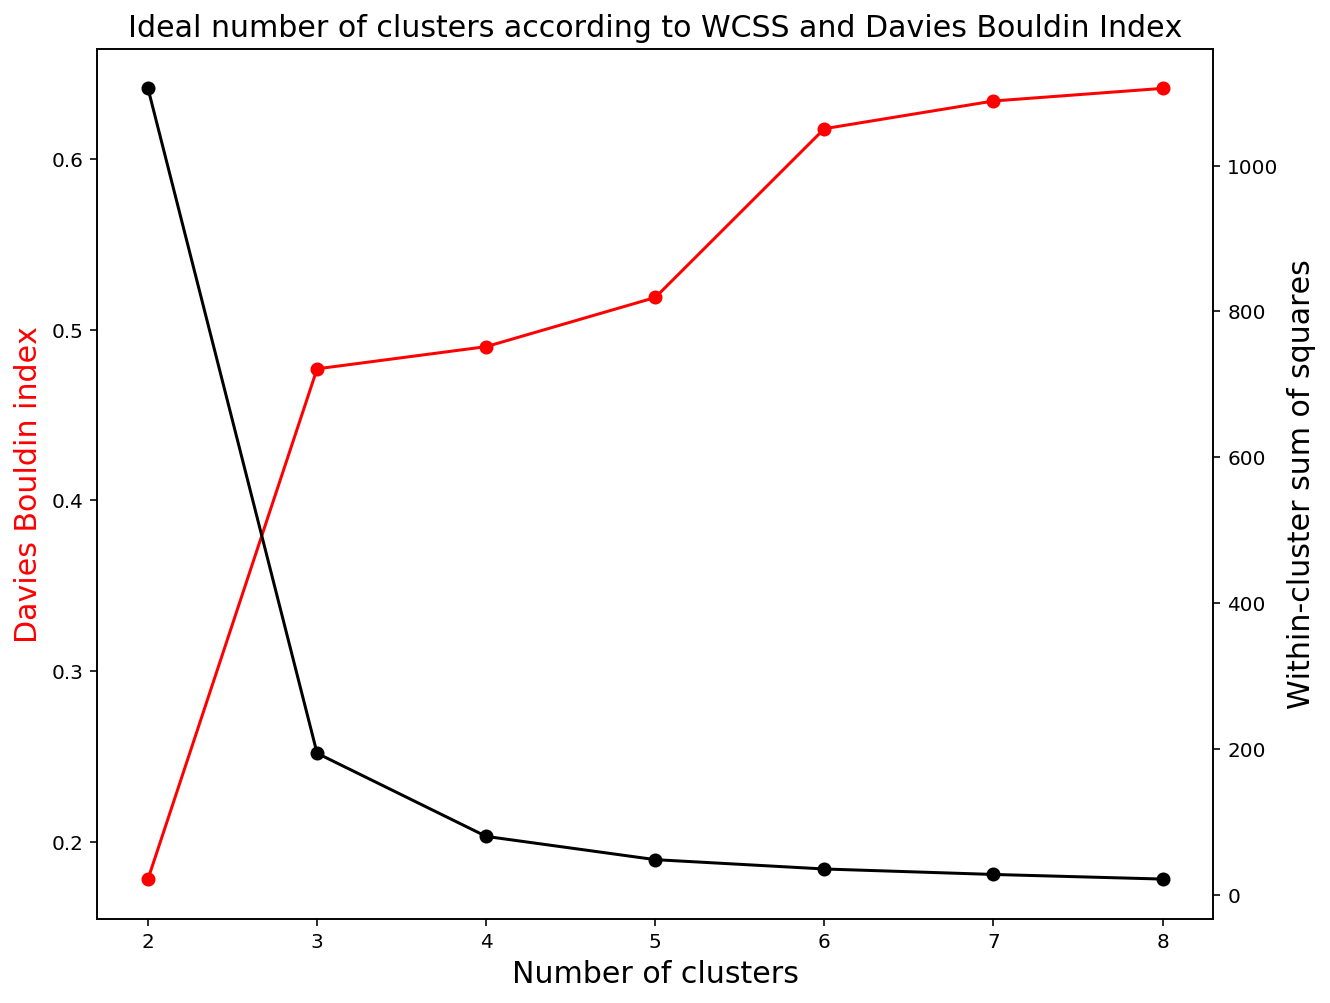

In [54]:
import sklearn.metrics as metrics
scores_battery = []
k = [2, 3, 4, 5, 6, 7, 8]
for i in k:
    y_battery = KMeans(n_clusters = i, max_iter=1000, random_state = 0).fit_predict(df_battery_PCA)
    score_b = metrics.davies_bouldin_score(df_battery_PCA, y_battery)
    scores_battery.append(score_b)
    print(score_b)
    
fig, ax3 = plt.subplots(figsize=(10,8))
ax4 = ax3.twinx() 

ax3.plot(k, scores_battery, 'r-', marker = 'o')
ax4.plot(k, WCSS_battery, 'k-', marker = 'o')

plt.title('Ideal number of clusters according to WCSS and Davies Bouldin Index', fontsize = 15)
ax3.set_xlabel('Number of clusters', fontsize = 15)
ax3.set_ylabel('Davies Bouldin index', color='r', fontsize = 15)
ax4.set_ylabel('Within-cluster sum of squares', color='k', fontsize = 15)

plt.show()
fig.savefig('Ideal number of clusters according to WCSS and Davies Bouldin Index_Battery.png')

In [55]:
#set K-means again with number of clusters equal 4
K = 4
kmeans_battery_pca = KMeans(n_clusters = K, init ='k-means++', random_state =42)
#fit data with k-means pca model
kmeans_battery_pca.fit(df_battery_PCA)
df_battery_PCA.loc[:, 'cluster'] = kmeans_battery_pca.labels_

In [56]:
# transform the nominal values of battery weight, full charge voltage and battery capacity
ideal_battery = pd.DataFrame(data={'battery_weight': [2.8], 'fullcharge_voltage': [36], 'battery_capacity': [0.4]})
ideal_battery = (ideal_battery - df_battery.min()) / (df_battery.max() - df_battery.min())
ideal_battery = pca_battery.transform(ideal_battery)
ideal_battery = pd.DataFrame(ideal_battery, columns=['c1', 'c2'])
print (ideal_battery)
print(f"Ideal bike battery belongs to class {kmeans_battery_pca.predict(ideal_battery)[0]}")

         c1        c2
0 -0.076749  0.000097
Ideal bike battery belongs to class 0


In [57]:
ideal_battery = pd.DataFrame(data={'battery_weight': [2.8], 'fullcharge_voltage': [36], 'battery_capacity': [0.4]})
ideal_battery = (ideal_battery - df_battery.min()) / (df_battery.max() - df_battery.min())
ideal_battery = pca_battery.transform(ideal_battery)
ideal_battery = pd.DataFrame(ideal_battery, columns=['c1', 'c2'])
print (ideal_battery)
print(f"Ideal bike battery belongs to class {kmeans_battery_pca.predict(ideal_battery)[0]}")




         c1        c2
0 -0.076749  0.000097
Ideal bike battery belongs to class 0


### Depict the clusters in a 2D scatter plot by utilizing the tranformed data

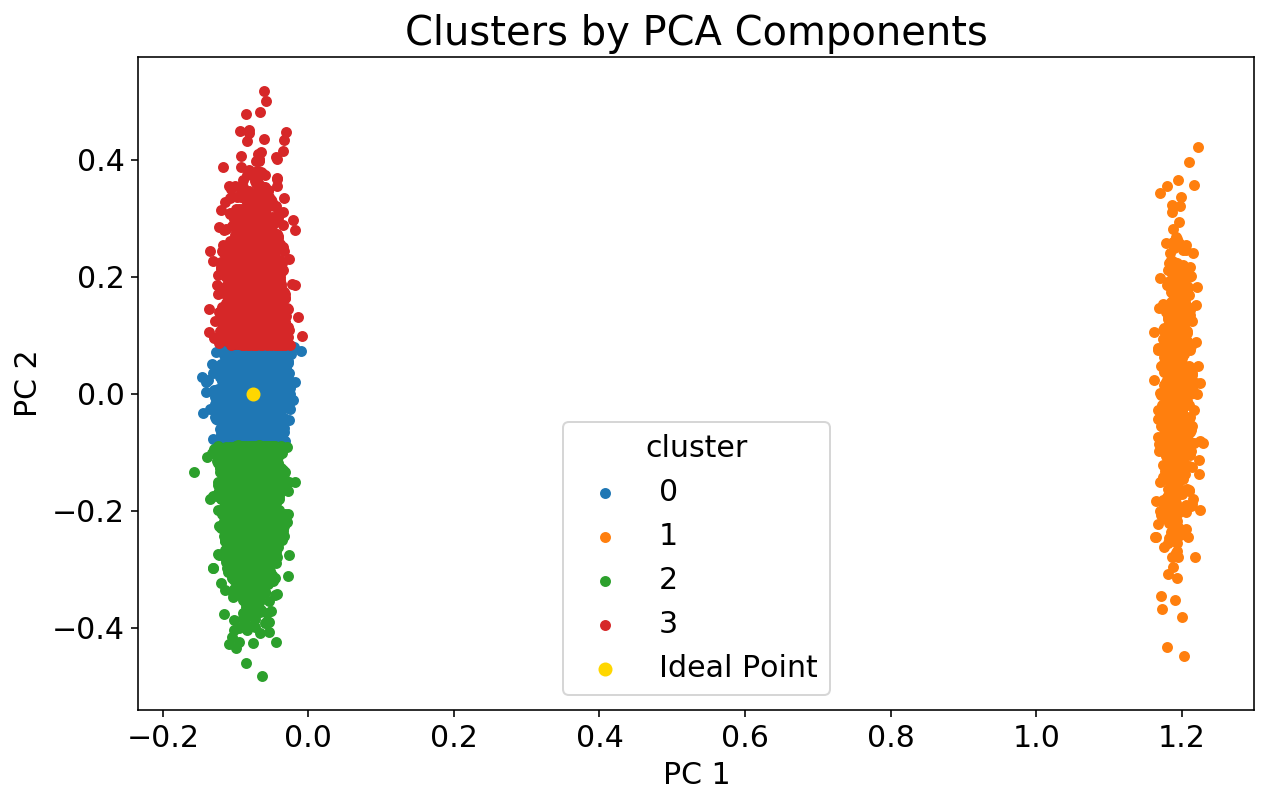

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

for cluster in range(K):
    df_battery_PCA.groupby('cluster').get_group(cluster).plot.scatter('PC 1', 'PC 2', 
                                                                 color='C' + str(cluster),
                                                                 ax=ax, label=cluster, fontsize = 15.0)
a = ideal_battery['c1']
b = ideal_battery['c2']
ax.scatter(a, b, color='gold', label='Ideal Point')

ax.legend(title='cluster', fontsize = 15.0, title_fontsize = 15)

#Plot data by PCA Components. The X axis is the first component, Y axis is the second
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)

plt.title('Clusters by PCA Components', fontsize = 20)
plt.show()
fig.savefig('Clusters by PCA Components_Battery.png')

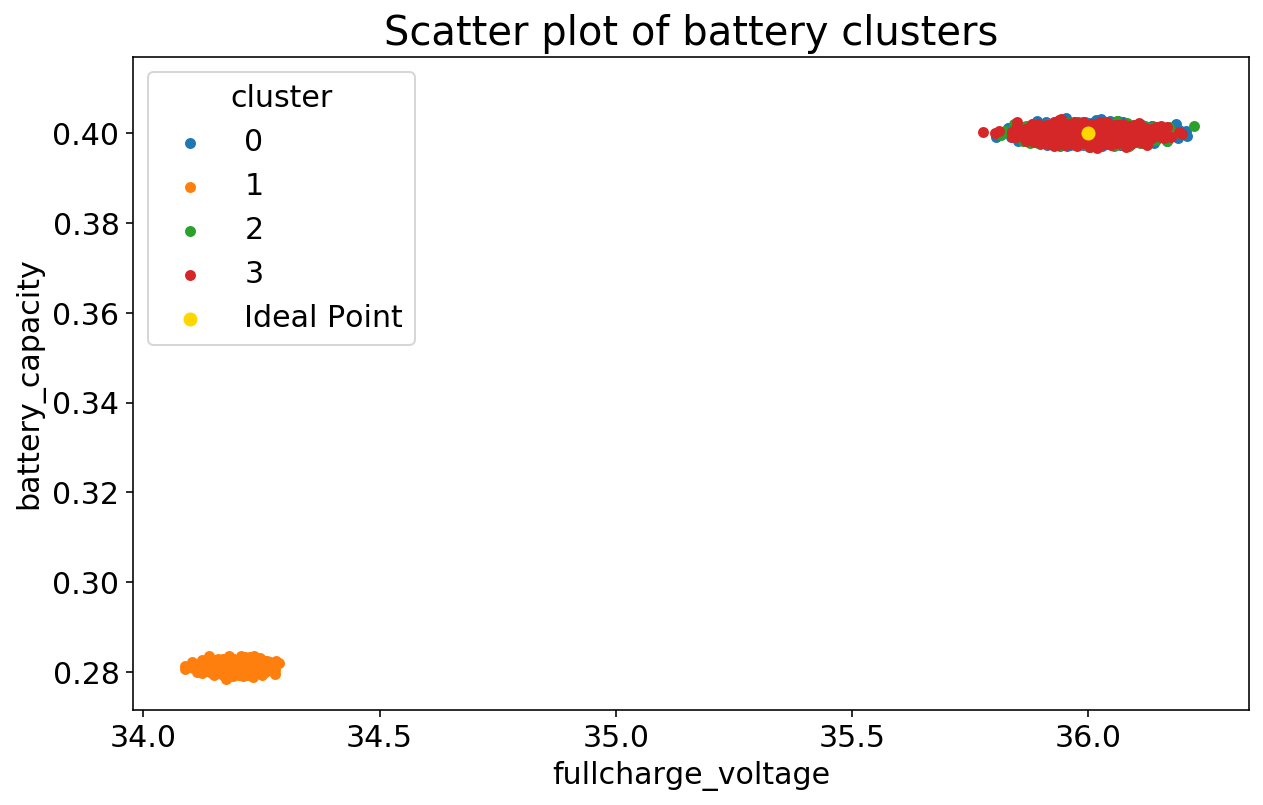

In [59]:
df_battery.loc[:, 'cluster'] = kmeans_battery_pca.labels_
fig, ax = plt.subplots(figsize=(10, 6))

for cluster in range(K):
    df_battery.groupby('cluster').get_group(cluster).plot.scatter('fullcharge_voltage', 'battery_capacity', 
                                                                 color='C' + str(cluster),
                                                                 ax=ax, label=cluster, fontsize = 15.0)
a = 36
b = 0.4
ax.scatter(a, b, color='gold', label='Ideal Point')

ax.legend(title='cluster', fontsize = 15.0, title_fontsize = 15)

# the X axis is fullcharge_voltage, Y axis is battery_capacity
ax.set_xlabel('fullcharge_voltage', fontsize = 15)
ax.set_ylabel('battery_capacity', fontsize = 15)

plt.title('Scatter plot of battery clusters', fontsize = 20.0)
plt.show()
fig.savefig('Scatter plot of battery clusters.png')

### Describe and calculate the percentage of each cluster

In [60]:
clusterbattery_0 = df.iloc[np.where(kmeans_battery_pca.labels_ == 0)]
print(f"{round(len(clusterbattery_0)/len(df)*100, 2)}% of bike batteries belong to class 0")
clusterbattery_0.describe()

44.2% of bike batteries belong to class 0


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000,4402.000000
mean,602.087765,584.007460,486.972764,632.996042,2.800075,36.000318,0.400006
std,0.870351,0.944273,1.012596,1.168648,0.001446,0.055116,0.000869
min,599.048517,580.228518,483.260766,629.310812,2.797510,35.803902,0.397192
25%,601.660820,583.362649,486.288220,632.574043,2.798854,35.963357,0.399409
50%,602.018025,584.001611,486.985888,632.981274,2.800114,35.999787,0.400010
75%,602.396458,584.641975,487.660758,633.374412,2.801286,36.037573,0.400595
max,605.586953,587.832851,490.446330,638.184032,2.802659,36.208308,0.403521


In [61]:
clusterbattery_1 = df.iloc[np.where(kmeans_battery_pca.labels_ == 1)]
print(f"{round(len(clusterbattery_1)/len(df)*100, 2)}% of bike batteries belong to class 1")
clusterbattery_1.describe()

6.04% of bike batteries belong to class 1


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000,602.000000
mean,601.960922,584.006904,486.998354,632.998660,2.799693,34.198396,0.281245
std,0.978977,0.933452,1.008336,0.961716,0.004206,0.034226,0.000865
min,599.239595,581.402650,484.175763,629.699596,2.786907,34.088173,0.278370
25%,601.243550,583.362871,486.323413,632.318493,2.796907,34.176726,0.280680
50%,601.973932,583.984030,486.982009,633.037513,2.799787,34.197159,0.281252
75%,602.622589,584.647382,487.655751,633.701001,2.802511,34.221831,0.281817
max,604.929060,586.713380,489.865586,636.008261,2.813058,34.286935,0.283582


In [62]:
clusterbattery_2 = df.iloc[np.where(kmeans_battery_pca.labels_ == 2)]
print(f"{round(len(clusterbattery_2)/len(df)*100, 2)}% of bike batteries belong to class 2")
clusterbattery_2.describe()

24.16% of bike batteries belong to class 2


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000,2406.000000
mean,602.065274,584.011337,486.981297,632.996061,2.805238,36.001027,0.400002
std,0.854048,0.948810,1.001855,1.111467,0.002034,0.055972,0.000868
min,599.498170,580.401081,483.227181,629.444978,2.802664,35.815814,0.396926
25%,601.627558,583.362131,486.315508,632.585291,2.803624,35.961191,0.399420
50%,601.985466,584.033318,486.972374,632.989075,2.804726,36.001633,0.400025
75%,602.384368,584.692449,487.663024,633.395455,2.806419,36.039488,0.400599
max,605.789432,588.694467,490.317548,638.849165,2.814514,36.223812,0.402711


In [63]:
clusterbattery_3 = df.iloc[np.where(kmeans_battery_pca.labels_ == 3)]
print(f"{round(len(clusterbattery_3)/len(df)*100, 2)}% of bike batteries belong to class 3")
clusterbattery_3.describe()

25.59% of bike batteries belong to class 3


,top_tube,seat_tube,chainstay,front_center,battery_weight,fullcharge_voltage,battery_capacity
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,602.080279,584.016465,486.962431,633.031049,2.794915,35.998603,0.399982
std,0.884107,0.939435,1.028170,1.226348,0.002062,0.055825,0.000882
min,599.040237,580.401824,483.422358,629.536046,2.784446,35.777706,0.396743
25%,601.651232,583.397234,486.272547,632.584842,2.793827,35.962417,0.399401
50%,602.018555,584.006646,486.949498,632.981549,2.795357,35.997337,0.399999
75%,602.408415,584.633894,487.652248,633.384776,2.796548,36.036160,0.400583
max,605.915751,587.179274,490.802967,638.269824,2.797509,36.197393,0.403210


Overall remarks

In [72]:
df1 = pd.read_excel('data_clean.xlsx')
df1.loc[:, 'cluster_battery'] = kmeans_battery_pca.labels_
df1.loc[:, 'cluster_frame'] = kmeans_frame_pca.labels_

In [73]:
rel_contingency_table = pd.crosstab(index=df1.loc[:, 'cluster_battery'], columns=df1.loc[:, 'cluster_frame'], 
                                    margins=True, normalize=True)
rel_contingency_table

cluster_frame,0,1,2,3,4,All
cluster_battery,,,,,,
0,0.125013,0.141580,0.130535,0.018978,0.025906,0.442012
1,0.017070,0.019982,0.020183,0.002109,0.001105,0.060448
2,0.069083,0.077819,0.072397,0.009238,0.013054,0.241591
3,0.071192,0.078422,0.078924,0.012652,0.014761,0.255949
All,0.282358,0.317803,0.302038,0.042976,0.054825,1.000000
